# ESA ClouDInSAR

**Authors:**  
_Mattia Callegari, Eurac Research_  
_Michele Claus, Eurac Research_

**Release Date:**  
May 06, 2025

## Objectives:
- Learn how to interact with the CDSE burst catalog, performing a query based on your temporal and spatial range of interest.

- Understand why accessing single bursts can optimize your workflow.

- Filter the desired products based on track and polarization.

- Get the perpendicular and temporal baseline of the selected product pairs and select only the required for our analysis.

## 0. Import libraries

In [18]:
import os
from dateutil.parser import parse
import datetime
import urllib
import json
import numpy as np
import pandas as pd
from shapely.geometry import shape
import folium
from folium.plugins import Draw
from folium.plugins.treelayercontrol import TreeLayerControl
import leafmap
from IPython.display import JSON

## 1. Input definition

Select the temporal range of interest defining the start and end dates

In [4]:
start_date = '2024-01-01'
end_date = '2025-01-30'

Define an area of interest by drawing in the map using the rectangle selection tool

In [5]:
m = leafmap.Map(center=(47.005, 11.507), zoom=7.5)
m

Map(center=[47.005, 11.507], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom…

In [6]:
feat = m.draw_features
geom_dict = feat[0]['geometry']
geom = shape(geom_dict)
geom.wkt

'POLYGON ((11.553026 46.727813, 11.553026 46.806828, 11.789164 46.806828, 11.789164 46.727813, 11.553026 46.727813))'

## 2. CDSE Bursts Catalog Query

Retrieve the bursts info with an https request to the CDSE OData API.

In [7]:
https_request = f"https://catalogue.dataspace.copernicus.eu/odata/v1/Bursts?$filter=" + urllib.parse.quote(
    f"ContentDate/Start ge {start_date}T00:00:00.000Z and ContentDate/Start le {end_date}T23:59:59.000Z and "
    f"PolarisationChannels eq 'VV' and "
    f"OData.CSC.Intersects(area=geography'SRID=4326;{geom.wkt}')"
) + "&$top=1000"

with urllib.request.urlopen(https_request) as response:
    content = response.read().decode()
bursts = json.loads(content)
JSON(bursts)

<IPython.core.display.JSON object>

Extract the list of Sentinel-1 tracks and burst ids from the retireved list of products

In [8]:
bursts_uniqueTrack = {}
burstId_list = []
track_list = []
for b in bursts['value']:
    if b['RelativeOrbitNumber'] not in track_list:
        bursts_uniqueTrack[b['RelativeOrbitNumber']] = {}
        track_list.append(b['RelativeOrbitNumber'])
    burstId_subswath = f"BurstId: {b['BurstId']}, {b['SwathIdentifier']}"
    if burstId_subswath not in burstId_list:
        bursts_uniqueTrack[b['RelativeOrbitNumber']][burstId_subswath] = b['GeoFootprint']['coordinates']
        burstId_list.append(burstId_subswath)

## 3. Show On Map

Initialize the map, center it in the middle of the bursts and add the bursts footprint geometries.

In [9]:
lat, lon = [], []
for burst in bursts_uniqueTrack.values():
    for coords in burst.values():
        lat = lat + [c[1] for c in coords[0]]
        lon = lon + [c[0] for c in coords[0]]

m = folium.Map(
    location=[np.mean([max(lat), min(lat)]), np.mean([max(lon), min(lon)])],
    zoom_start=8
)

# Add the area of interest
if geom.geom_type == 'Point':
    folium.Marker([geom.y, geom.x]).add_to(m)

if geom.geom_type == 'Polygon':
    folium.Polygon(
        locations=[(y, x) for x, y in geom.exterior.coords],
        color='blue',
        fill=True,            
        fill_color='blue',    
        fill_opacity=0.4
    ).add_to(m)


# Add each burst grouped by track
children = []
for track, burst in bursts_uniqueTrack.items():
    children.append(
        {
            "label": f"Track {track}",
            "select_all_checkbox": True,
            "children": [{"label":str(b), "layer": folium.Polygon(locations=np.flip(np.squeeze(p), axis=1), color='red').add_to(m)} for b, p in burst.items()]
        }
    )

# Show the map
overlay_tree = {
    "label": "Burst Footprints",
    "select_all_checkbox": "Un/select all",
    "children": children
}

TreeLayerControl(overlay_tree=overlay_tree).add_to(m)
m

## 4. Plot Acquisition Calendar

To understand the result of our data query for Sentinel-1, we plot here a visual calendar showing on which date the corresponding track has been acquired.

In [10]:
import calendar
import matplotlib.pyplot as plt

def display_calendar(year, month, highlighted_dates={}):

    cal = calendar.monthcalendar(year, month)
    fig, ax = plt.subplots(figsize=(4, 2))
    ax.set_xticks([])
    ax.set_yticks([])
                
    for row, week in enumerate(cal):
        for col, day in enumerate(week):
            if day == 0:
                continue
            color = highlighted_dates.get(day, "white")
            ax.add_patch(plt.Rectangle((col - 0.5, row - 0.5), 1, 1, color=color, alpha=0.6))
            ax.text(col, row, str(day), ha="center", va="center", fontsize=12, weight='bold')

    ax.set_xlim(-0.5, 6.5)
    ax.set_ylim(len(cal) - 0.5, -0.5)
    ax.set_title(calendar.month_name[month] + f" {year}")
    plt.show()

In [11]:
date, track = [], [] 
for b in bursts['value']:
    date.append(b['BeginningDateTime'])
    track.append(b['RelativeOrbitNumber'])
df = pd.DataFrame(data={'date': date, 'track': track})
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df = df.drop_duplicates(subset=['track', 'year', 'month', 'day'])
df = df.sort_values(by='date', ascending=True)

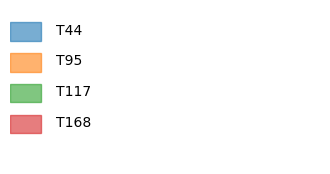

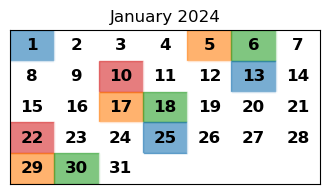

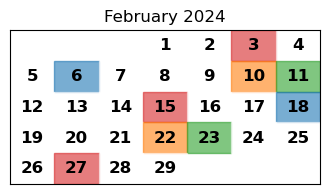

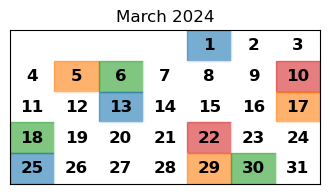

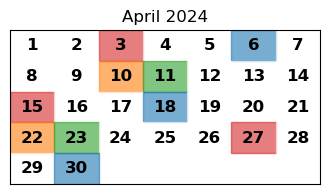

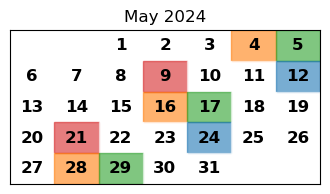

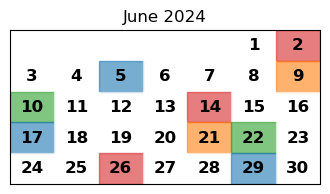

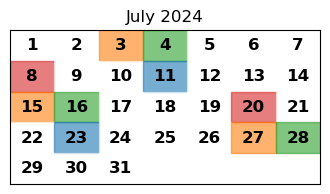

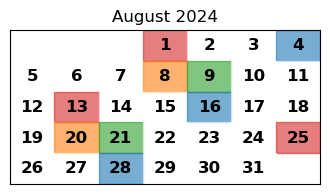

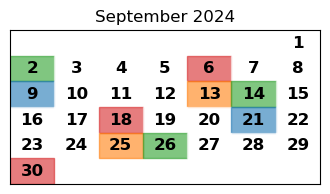

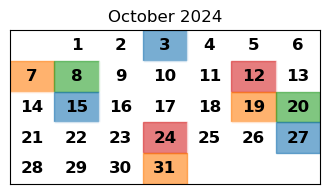

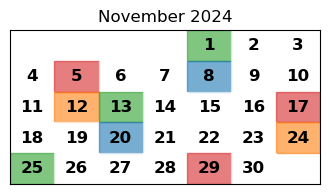

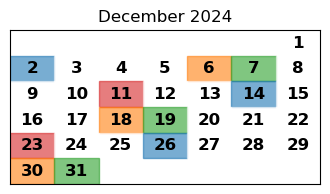

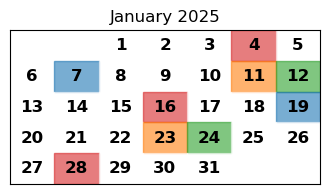

In [12]:
color_track = {}
fig, ax = plt.subplots(figsize=(4, len(df['track'].unique())*0.5))
for i, t in enumerate(df['track'].unique()):
    color_track[t] = f'C{i}'
    ax.add_patch(plt.Rectangle((0, -i*0.5), 0.1, 0.3, color=color_track[t], alpha=0.6))
    ax.text(0.15, -i*0.5+0.1, f'T{t}', fontsize=10)
ax.set_xlim(0, 1)
ax.set_ylim(-len(df['track'].unique())*0.5, 0.5)
ax.axis('off')
plt.show()

for year in df['year'].unique():
    df_year = df.loc[df['year'] == year, :]
    for month in df_year['month'].unique():
        h = {}
        for i, row in df_year.loc[df_year['month'] == month, :].iterrows():
            h[row['day']] = color_track[row['track']]
        display_calendar(year, month, h)

## 5. Filter with Track, Burst ID and Polarization

Select one of the available sub_swath_identifier (i.e. iw1, iw2, iw3) and burstId from the following list or from the map widget above.

In [13]:
for x in children:
  print(x["label"])
  for y in x["children"]:
    print("  " + y["label"]) 

Track 44
  BurstId: 92637, IW1
  BurstId: 92638, IW1
Track 95
  BurstId: 202701, IW3
  BurstId: 202702, IW3
Track 117
  BurstId: 249434, IW2
  BurstId: 249435, IW2
Track 168
  BurstId: 359499, IW1
  BurstId: 359500, IW1


Set the required polarization, subswath identifier and correspondant burst id.

In [14]:
track
sub_swath_identifier = "iw2"
burst_id = "249434"
polarization = "VV"

Get the product names of which we need to download the metadata

In [15]:
SAFE_image_list = []
S3_image_list = []
for b in bursts['value']:
    if b['SwathIdentifier'].lower() == sub_swath_identifier:
        if str(b["BurstId"]) == str(burst_id):
            if b["ParentProductName"] not in SAFE_image_list:
                SAFE_image_list.append((b["ParentProductName"]))
                S3_image_list.append((b["S3Path"].split(".SAFE")[0] + ".SAFE"))

## 6. Download Sentinel-1 metadata

Get the metadata from the S3 bucket (add your CDSE S3 credentials).  
The code in thhe next cell will download only the necessary metadata files required to compute the perpendicular baseline using the ESA SNAP toolbox.  
It will also create empty geotiff images and replicate the folder structure of a full Sentinel-1 product stored with the SAFE format. This will allow us to use SNAP for this task.

In [17]:
os.environ["AWS_ACCESS_KEY_ID"] = ""
os.environ["AWS_SECRET_ACCESS_KEY"] = ""

if polarization.lower()=="vv":
    include_pol='vv'
    exclude_pol='vh'
elif polarization.lower()=="vh":
    include_pol='vh'
    exclude_pol='vv'

s3_endpoint = "eodata.dataspace.copernicus.eu"

for im_safe, im_s3 in zip(SAFE_image_list,S3_image_list):
    print(im_safe)
    os.system(f"s5cmd --endpoint-url \"https://{s3_endpoint}\" cp --include \"*{sub_swath_identifier.lower()}*\" --exclude \"*{exclude_pol}*\"  --exclude \"*.tiff\" --include \"manifest.safe\" \"s3:/\"{im_s3}\"/*\" {im_safe}/")
    os.system(f"mkdir {im_safe}/measurement")

    command = f"s5cmd --endpoint-url \"https://{s3_endpoint}\" -r 5 ls \"s3:/\"{im_s3}\"/measurement/\" | grep -o '\S\+$' | grep {include_pol} | grep {sub_swath_identifier.lower()}"
    result = os.popen(command).read().splitlines()

    for im in result:
        command = f"gdal_create -ot Int8 -outsize 1 1 -bands 1 -burn 0 {im_safe}/measurement/{im}"
        os.system(command)

S1A_IW_SLC__1SDV_20240306T170721_20240306T170748_052864_0665F0_9D32.SAFE
cp s3://eodata/Sentinel-1/SAR/IW_SLC__1S/2024/03/06/S1A_IW_SLC__1SDV_20240306T170721_20240306T170748_052864_0665F0_9D32.SAFE/manifest.safe S1A_IW_SLC__1SDV_20240306T170721_20240306T170748_052864_0665F0_9D32.SAFE/manifest.safe
cp s3://eodata/Sentinel-1/SAR/IW_SLC__1S/2024/03/06/S1A_IW_SLC__1SDV_20240306T170721_20240306T170748_052864_0665F0_9D32.SAFE/annotation/rfi/rfi-s1a-iw2-slc-vv-20240306t170723-20240306t170748-052864-0665f0-005.xml S1A_IW_SLC__1SDV_20240306T170721_20240306T170748_052864_0665F0_9D32.SAFE/annotation/rfi/rfi-s1a-iw2-slc-vv-20240306t170723-20240306t170748-052864-0665f0-005.xml
cp s3://eodata/Sentinel-1/SAR/IW_SLC__1S/2024/03/06/S1A_IW_SLC__1SDV_20240306T170721_20240306T170748_052864_0665F0_9D32.SAFE/annotation/calibration/noise-s1a-iw2-slc-vv-20240306t170723-20240306t170748-052864-0665f0-005.xml S1A_IW_SLC__1SDV_20240306T170721_20240306T170748_052864_0665F0_9D32.SAFE/annotation/calibration/noise-s1

## 7. ESA SNAP - extract optimal master and perpendicular baselines

Use the SNAP Python bindings via the `esa_snappy` package and extract firstly the optimal master date:

Now extract the temporal baselines from the list of products

In [31]:
import esa_snappy as snappy

products = []
for im in SAFE_image_list:
    products.append(snappy.ProductIO.readProduct(im))
InSARStackOverview = snappy.jpy.get_type('eu.esa.sar.insar.gpf.InSARStackOverview')
optimal_master = InSARStackOverview.findOptimalMasterProduct(products).getName()
print(f"The optimal master product selected by SNAP is: {optimal_master}")

The optimal master product selected by SNAP is: S1A_IW_SLC__1SDV_20240821T170720_20240821T170747_055314_06BE95_CC41


In [36]:
# import the stack operator
create_stack = snappy.jpy.get_type('eu.esa.sar.insar.gpf.coregistration.CreateStackOp')
# 1st argument: list of products between which you want to compute the baseline
# 2nd argument: a product that will receive the baselines as new metadata
master = snappy.ProductIO.readProduct(optimal_master + ".SAFE")
create_stack.getBaselines(products, master)
# Now there is a new piece of metadata in product one called 'Baselines'
baseline_root_metadata = master.getMetadataRoot().getElement('Abstracted_Metadata').getElement('Baselines')
# You can now display all the baselines between all master/slave configurations
master_ids = list(baseline_root_metadata.getElementNames())
master_dates = []
slave_dates = []
perpendicular_baselines = []
delta_times = []
for master_id in master_ids:
    slave_ids = list( baseline_root_metadata.getElement(master_id).getElementNames())
    for slave_id in slave_ids:
        # print(f'{master_id}, {slave_id}')
        snap_date_mst = master_id.split("_")[1]
        date_obj_mst = parse(snap_date_mst)
        snap_date_slv = slave_id.split("_")[1]
        date_obj_slv = parse(snap_date_slv)
        
        delta_time = date_obj_mst - date_obj_slv
        # if delta_time == datetime.timedelta(0):
            # continue
        master_dates.append(date_obj_mst)
        slave_dates.append(date_obj_slv)
        delta_times.append(delta_time)
        baseline_metadata = baseline_root_metadata.getElement(master_id).getElement(slave_id)
        for baseline in list(baseline_metadata.getAttributeNames()):
            if baseline == "Perp Baseline":
                perpendicular_baseline = baseline_metadata.getAttributeString(baseline)
                perpendicular_baselines.append(perpendicular_baseline)
                print(f'{baseline}: {perpendicular_baseline}')

Perp Baseline: 0.0
Perp Baseline: 32.158416748046875
Perp Baseline: -46.4830207824707
Perp Baseline: 45.744422912597656
Perp Baseline: 49.67479705810547
Perp Baseline: 54.089019775390625
Perp Baseline: -25.899009704589844
Perp Baseline: -74.0414047241211
Perp Baseline: 232.1392822265625
Perp Baseline: 106.1134033203125
Perp Baseline: 117.61506652832031
Perp Baseline: 181.58047485351562
Perp Baseline: 312.0473327636719
Perp Baseline: 420.40911865234375
Perp Baseline: 325.82537841796875
Perp Baseline: 383.9298400878906
Perp Baseline: 193.76785278320312
Perp Baseline: 147.13941955566406
Perp Baseline: -23.79122543334961
Perp Baseline: 271.9586181640625
Perp Baseline: -41.44721603393555
Perp Baseline: 147.72279357910156
Perp Baseline: 230.59449768066406
Perp Baseline: 229.99429321289062
Perp Baseline: -220.82583618164062
Perp Baseline: 163.4061737060547
Perp Baseline: 134.44369506835938
Perp Baseline: 105.18638610839844
Perp Baseline: -23.17386245727539
Perp Baseline: 137.2498016357422
Per

Create a pandas Dataframe containing all the dates combinations and the associated perpendicular and temporal baselines.

In [37]:
import pandas as pd
df = pd.DataFrame([[a,b,float(c),d] for a,b,c,d in zip(master_dates,slave_dates,perpendicular_baselines,delta_times)], columns=["master_date","slave_date","perp_baseline","temp_baseline"])
df

,master_date,slave_date,perp_baseline,temp_baseline
0,2024-03-06,2024-03-06,0.000000,0 days
1,2024-03-06,2024-02-23,32.158417,12 days
2,2024-03-06,2024-03-18,-46.483021,-12 days
3,2024-03-06,2024-01-06,45.744423,60 days
4,2024-03-06,2024-01-18,49.674797,48 days
...,...,...,...,...
1084,2025-01-24,2024-10-20,-175.087479,96 days
1085,2025-01-24,2024-11-25,-14.789785,60 days
1086,2025-01-24,2024-12-19,62.941406,36 days
1087,2025-01-24,2025-01-12,78.610283,12 days


## 8. Filter Data

Select the maximum temporal (days) and perpendicular (meters) baselines

In [53]:
# extract the zero reference date from the optimal master product
# master_date = "2024-11-01"
zero_reference_date = optimal_master.split("_")[5][:4] + "-" + optimal_master.split("_")[5][4:6] + "-" + optimal_master.split("_")[5][6:8]

max_temporal_baseline = 24 # days
max_perpendicular_baseline = 400 # meters, absolute value

filter_mask = np.bitwise_and(abs(df["temp_baseline"])<=datetime.timedelta(max_temporal_baseline),abs(df["perp_baseline"])<=max_perpendicular_baseline)
df_filtered = df[filter_mask].reset_index()

## 7. Visualize selected pairs

Plot the graph showing the existing connections between date pairs after the filtering:

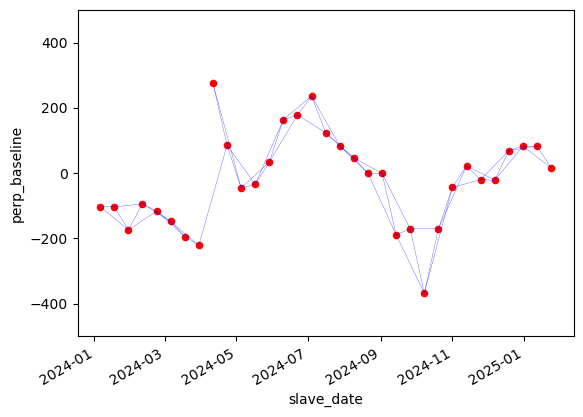

In [54]:
ax = df[df["master_date"]==zero_reference_date].plot.scatter(
    x='slave_date',
    y='perp_baseline',
    color="red",
    ylim=(-500, 500))
for x in df_filtered.index:
    single = df_filtered.iloc[[x]]
    point_1 = df[np.bitwise_and(df["master_date"]==zero_reference_date,np.bitwise_or(df["slave_date"]==single["master_date"].values[0],df["slave_date"]==single["slave_date"].values[0]))]
    ax = point_1.plot.line(
            x='slave_date',
            y='perp_baseline',
            legend=False,
            ax=ax,
            color="blue",
            linewidth=0.1)
plt.show()

Create date pairs list, used as input to the SNAP workflow:

In [55]:
def reformat_date_string(date):
    return date[:4] + date[5:7] + date[8:10]
sbas_dates_list = [f"{reformat_date_string(str(df_filtered.iloc[[x]]['master_date'].values[0]))}_{reformat_date_string(str(df_filtered.iloc[[x]]['slave_date'].values[0]))}" for x in df_filtered.index]
sbas_dates_list

['20240306_20240306',
 '20240306_20240223',
 '20240306_20240318',
 '20240306_20240211',
 '20240306_20240330',
 '20240223_20240306',
 '20240223_20240223',
 '20240223_20240318',
 '20240223_20240211',
 '20240223_20240130',
 '20240318_20240306',
 '20240318_20240223',
 '20240318_20240318',
 '20240318_20240330',
 '20240106_20240106',
 '20240106_20240118',
 '20240106_20240130',
 '20240118_20240106',
 '20240118_20240118',
 '20240118_20240211',
 '20240118_20240130',
 '20240211_20240306',
 '20240211_20240223',
 '20240211_20240118',
 '20240211_20240211',
 '20240211_20240130',
 '20240130_20240223',
 '20240130_20240106',
 '20240130_20240118',
 '20240130_20240211',
 '20240130_20240130',
 '20240330_20240306',
 '20240330_20240318',
 '20240330_20240330',
 '20240330_20240423',
 '20240423_20240330',
 '20240423_20240423',
 '20240423_20240505',
 '20240423_20240517',
 '20240423_20240411',
 '20240505_20240423',
 '20240505_20240505',
 '20240505_20240517',
 '20240505_20240529',
 '20240505_20240411',
 '20240517

Plot the graph showing the existing connections for a single reference date after the filtering:

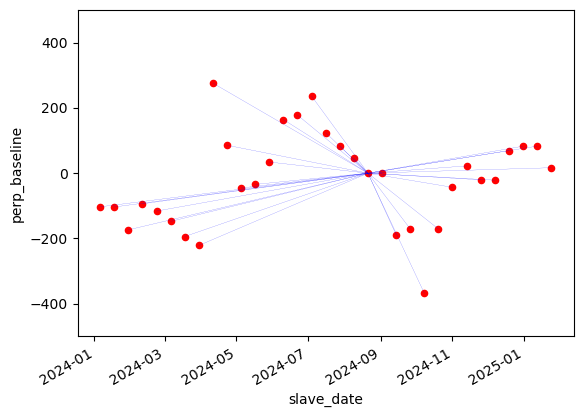

In [56]:
df_filtered_ = df[df["master_date"]==zero_reference_date].reset_index()
ax = df[df["master_date"]==zero_reference_date].plot.scatter(
    x='slave_date',
    y='perp_baseline',
    color="red",
    ylim=(-500, 500))
for x in df_filtered_.index:
    single = df_filtered_.iloc[[x]]
    point_1 = df[np.bitwise_and(df["master_date"]==zero_reference_date,np.bitwise_or(df["slave_date"]==single["master_date"].values[0],df["slave_date"]==single["slave_date"].values[0]))]
    ax = point_1.plot.line(
            x='slave_date',
            y='perp_baseline',
            legend=False,
            ax=ax,
            color="blue",
            linewidth=0.1)
plt.show()

Create date pairs list, used as input to the SNAP workflow:

In [57]:
ps_dates_list = [f"{reformat_date_string(str(df_filtered_.iloc[[x]]['master_date'].values[0]))}_{reformat_date_string(str(df_filtered_.iloc[[x]]['slave_date'].values[0]))}" for x in df_filtered_.index]
ps_dates_list

['20240821_20240306',
 '20240821_20240223',
 '20240821_20240318',
 '20240821_20240106',
 '20240821_20240118',
 '20240821_20240211',
 '20240821_20240130',
 '20240821_20240330',
 '20240821_20240423',
 '20240821_20240505',
 '20240821_20240517',
 '20240821_20240529',
 '20240821_20240610',
 '20240821_20240411',
 '20240821_20240622',
 '20240821_20240704',
 '20240821_20240809',
 '20240821_20240902',
 '20240821_20240926',
 '20240821_20240716',
 '20240821_20240914',
 '20240821_20240821',
 '20240821_20240728',
 '20240821_20241231',
 '20240821_20241008',
 '20240821_20241113',
 '20240821_20241207',
 '20240821_20241101',
 '20240821_20241020',
 '20240821_20241125',
 '20240821_20241219',
 '20240821_20250112',
 '20240821_20250124']